In [210]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `c:\Users\sesch\Git\tinympc-julia\quadrotor_quat\Project.toml`

In [211]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random
using Printf
using MeshCat
using TrajOptPlots
using RobotZoo:Quadrotor
using StaticArrays
using GeometryTypes
using ColorTypes

In [278]:
vis = Visualizer()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8718
└ @ MeshCat C:\Users\sesch\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat Visualizer with path /meshcat at http://127.0.0.1:8718

In [279]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [212]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [335]:
# Quadrotor parameters
m = 0.035
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008
ℓ = 0.046/sqrt(2)
scale = 65535
kt = 2.245365e-6*scale # u is PWM in range [0...1]
# kt=1
km = kt*thrustToTorque #4.4733e-8

# #Quadrotor parameters
# m = 0.5
# ℓ = 0.1750
# J = Diagonal([0.0023, 0.0023, 0.004])
# g = 9.81
# kt=1.0
# km=0.0245


# Problem setup
h = 1/500

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4      # number of controls
nx = Nx̃
nu = Nu

4

In [336]:
# function quad_dynamics(x,u)
#   r = x[1:3]
#   q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
#   v = x[8:10]
#   ω = x[11:13]
#   Q = qtoQ(q)
  
#   ṙ = v
#   q̇ = 0.5*L(q)*H*ω
  
#   v̇ = [0; 0; -g] + (1/m)*Q*[zeros(2,4); kt*ones(1,4)]*u 

#   ω̇ = J\(-hat(ω)*J*ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; -ℓ*kt ℓ*kt ℓ*kt -ℓ*kt; -km km -km km]*u)
  
#   return [ṙ; q̇; v̇; ω̇]
# end
function quad_dynamics(x,u)
  r = x[1:3]
  q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)
  
  ṙ = Q*v
  q̇ = 0.5*L(q)*H*ω
  
  v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
  
  ω̇ = J\(-hat(ω)*J*ω + [0 ℓ*kt 0 -ℓ*kt; -ℓ*kt 0 ℓ*kt 0; km -km km -km]*u)
  
  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5*h*f1, u)
  f3 = quad_dynamics(x + 0.5*h*f2, u)
  f4 = quad_dynamics(x + h*f3, u)
  xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
  xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [337]:
#Goal state
@show uhover = (m*g/kt/4)*ones(4) # m = 30g and max thrust = 60g
# @show uhover = (m*g/4)*ones(4) # m = 30g and max thrust = 60g
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

uhover = (((m * g) / kt) / 4) * ones(4) = [0.5833333520642209, 0.5833333520642209, 0.5833333520642209, 0.5833333520642209]


In [338]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u 
end

discrete_dynamics (generic function with 1 method)

In [339]:
# display("Ã, cond(Ã)")
# display(Ã)
# display(cond(Ã))
# display("B̃, cond(B̃)")
# display(B̃)
# display(cond(B̃))

In [340]:
# IHLQR terminal cost
max_IHLQR_iters = 2000
P = [zeros(nx,nx) for i = 1:max_IHLQR_iters]   # cost to go quadratic term
p = [zeros(nx) for i = 1:max_IHLQR_iters]      # cost to go linear term
d = [zeros(nu) for i = 1:max_IHLQR_iters-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:max_IHLQR_iters-1] # feedback gain

# Cost weights
max_dev_x = [0.1; 0.1; 0.1;  0.5; 0.5; 0.05;  0.5; 0.5; 0.5;  0.5; 0.5; 0.1]
max_dev_u = [0.5; 0.5; 0.5; 0.5]/10
# max_dev_x = [0.1; 0.1; 0.05;  0.5; 0.5; 0.03;  0.5; 0.5; 0.5;  0.7; 0.7; 0.2]
# max_dev_u = [0.5; 0.5; 0.5; 0.5]/6
# Q = diagm(1 ./(max_dev_x.^2))
# R = diagm(1 ./(max_dev_u.^2))

# Q = Array(Diagonal([10; 10; 10; 1; 1; 1; 1; 1; 1; 1; 1; 1.]));
Q = Array(BlockDiagonal([1.0*I(3), 0.001*I(Nx̃-3)]));
R = Array(1*I(Nu));

# # Cost weights
# Q = Array(I(Nx̃));
# # Q = Array(BlockDiagonal([1.0*I(3), 0.001*I(Nx̃-3)]));
# R = Array(0.01*I(Nu));

Qf = 1*Q

# PENALTY - important!!
# ρ = 250.0
# R̃ = R + ρ*I  
R̃ = R

# Precompute
cache = (
    Kinf = zeros(nu,nx),
    Pinf = zeros(nx,nx),
    Quu_inv = zeros(nu,nu),
    AmBKt = zeros(nx,nx), 
    coeff_d2p = zeros(nx,nu), 
)

P[max_IHLQR_iters] .= Qf
for k = (max_IHLQR_iters-1):-1:1
    K[k] .= (R̃ + B̃'*P[k+1]*B̃)\(B̃'*P[k+1]*Ã)
    P[k] .= Q + Ã'*P[k+1]*(Ã - B̃*K[k])
end
cache.Kinf .= K[1]
cache.Pinf .= P[1]
cache.AmBKt .= (Ã - B̃*K[1])'

cache.Quu_inv .= (R̃ + B̃'*cache.Pinf*B̃)\I;

cache.coeff_d2p .= cache.Kinf'*R̃ - cache.AmBKt*cache.Pinf*B̃;


# display("Q")
# display(Q)
# display("R")
# display(R)

# display("Kinf, cond(Kinf)")
# display(cache.Kinf)
# display(cond(cache.Kinf))
# display("Pinf, cond(Pinf)")
# display(cache.Pinf)
# display(cond(cache.Pinf))
# display("AmBKt, cond(AmBKt)")
# display(cache.AmBKt)
# display(cond(cache.AmBKt))
# display("Quu_inv, cond(Quu_inv)")
# display(cache.Quu_inv)
# display(cond(cache.Quu_inv))
# display("coeff_d2p, cond(coeff_d2p)")
# display(cache.coeff_d2p)
# display(cond(cache.coeff_d2p))


12×4 Matrix{Float64}:
 -2.25371e-7    2.1481e-7    -1.95765e-7    2.06326e-7
  8.85109e-8   -8.93295e-8    7.96404e-8   -7.88218e-8
 -1.23235e-13  -1.22347e-13  -1.22569e-13  -1.23235e-13
 -5.65637e-7    5.3873e-7    -5.08054e-7    5.34961e-7
 -1.40631e-6    1.37125e-6   -1.28109e-6    1.31616e-6
 -4.21184e-5    4.07994e-5   -3.78486e-5    3.91676e-5
 -1.90732e-7    1.84857e-7   -1.71586e-7    1.77461e-7
  7.62177e-8   -7.37303e-8    6.84889e-8   -7.09763e-8
 -1.60982e-14  -1.59872e-14  -1.60982e-14  -1.59872e-14
 -6.3891e-8     6.18789e-8   -5.74159e-8    5.9428e-8
 -1.59836e-7    1.54843e-7   -1.43659e-7    1.48652e-7
 -2.62486e-6    2.54268e-6   -2.35882e-6    2.441e-6

In [346]:
#Feedback tracking controller
include("tinyMPC-ADMM-dt.jl")
N = 10
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)


#Create trajectory to follow
Δx̃ref = [zeros(nx) for i = 1:Nt]
ΔUref = [zeros(nu) for i = 1:Nt-1]

# Figure-eight
scale = 1
Xref = [[scale*sin(2*t)/2; scale*cos(t); 1; 1; zeros(9)] for t = range(-pi/2, 3*pi/2, length = Nt)];

# Velocity reference: speeds up the tracking but less smooth
for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/h
end


u_min = -uhover + 0.1*[1; 1; 1; 1]
u_max =  0.9*[1; 1; 1; 1] - uhover

# state is x y v θ
x_min = -100*ones(nx)
x_min[3] = -0.2
x_max = 100*ones(nx)
x_max[3] = 0.2

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
Z = [zeros(nu) for i = 1:N-1]
Znew = [zeros(nu) for i = 1:N-1]
Y = [zeros(nu) for i = 1:N-1]

params = (
    nx = nx, nu = nu,
    N = N, Q = Q, R = R, Qf = Qf,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Δx̃ref = Δx̃ref, ΔUref = ΔUref, 
    Xref = Xref, h = h, cache = cache
);

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
qq = [zeros(nx) for i = 1:N]
r = [zeros(nu) for i = 1:N-1]

verbose = 0
function controller_mpc(params, x, k)
    q = x[4:7]
    ϕ = qtorp(L(Xref[k][4:7])'*q)
    
    Δx̃ = [x[1:3]-Xref[k][1:3]; ϕ; x[8:10]-Xref[k][8:10]; x[11:13]-Xref[k][11:13]]
    X[1] .= Δx̃
    # u, status = solve_admm!(params, qq, R̃, r, P, p, K, d, X, U, Z, Znew, Y; ρ=ρ, abs_tol=1e-2, max_iter=100)
    # u = -cache.Kinf*(Δx̃ - Δx̃ref[k]) # LQR
    u = -cache.Kinf*Δx̃ # LQR
    # display(iters[k])
    # status == 0 && display("Max iteration reached")
    return u + uhover
end

#ASK: Do I need to stretch the reference?
function update_reference(params, k)
    Uref_ = 1*ΔUref[k:N+k-2]
    Xref_ = 1*Δx̃ref[k:N+k-1]

    params1 = (; params..., Uref = Uref_, Xref = Xref_)  # update ref
    return params1
end


update_reference (generic function with 1 method)

In [347]:
# Simulation
uhist = [zeros(Nu) for i in 1:Nt-1]
xhist = [zeros(Nx) for i in 1:Nt]
Random.seed!(12);
# xhist[1] .= [rg+0*randn(3)/3; L(qg)*rptoq([1; 0; 0]); vg; ωg]  # initial conditions
xhist[1] .= Xref[1]
# xhist[1] .= Xref[1]; xhist[1][1:3] += rand(3)*0.2
backward_pass!(Q,qq,R̃,r,P,p,K,d,params)
Nsim = Nt - N# - 500
for k = 1:Nsim
# for k = 1:3
    params1 = update_reference(params, k)
    # display(params1.Xref)
    # display(xhist[k])
    # shift_fill(U)
    uhist[k] = controller_mpc(params1, xhist[k], k)
    # uhist[k] = clamp.(uhist[k], (uhover+u_min)[1], (uhover+u_max)[1])
    xhist[k+1] = quad_dynamics_rk4(xhist[k],uhist[k]) 
end

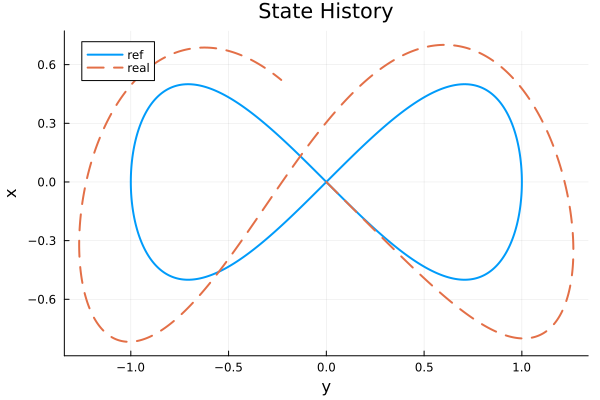

In [348]:
Xsim_m = mat_from_vec(Xref)
plot(Xsim_m[2,:],Xsim_m[1,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(xhist[1:Nsim])   
display(plot!(Xsim_m[2,:],Xsim_m[1,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

In [349]:
delete!(vis["XrefLine"])
XrefLine = [Point(x[1], x[2], x[3]) for x in Xref]
setobject!(vis["XrefLine"], Object(PointCloud(XrefLine), LineBasicMaterial(color=Colors.RGBA(0.,0.6,1.)), "Line"))
delete!(vis["xhistLine"])
xhistLine = [Point(x[1], x[2], x[3]) for x in xhist[1:end-N]]
setobject!(vis["xhistLine"], Object(PointCloud(xhistLine), LineBasicMaterial(color=Colors.RGBA(1,0.6,0.)), "Line"))

MeshCat Visualizer with path /meshcat/xhistLine at http://127.0.0.1:8718

In [350]:
X1 = [SVector{13}(x) for x in xhist];
visualize!(vis, model, t_vec[end-N], X1)

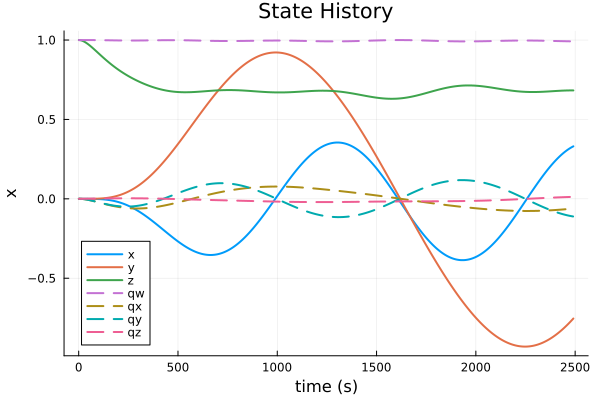

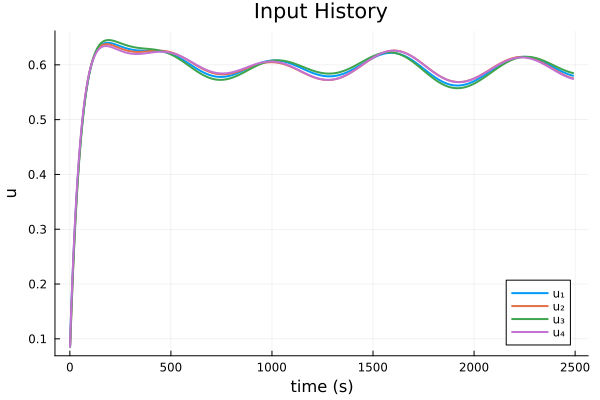

63.59513279325143

In [285]:
Xsim_m = mat_from_vec(xhist[1:Nsim]-0*Xref[1:Nsim])   
Usim_m = mat_from_vec(uhist[1:Nsim-1])   
display(plot(Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
norm(xhist[1:Nsim]-1*Xref[1:Nsim])

In [227]:
function export_mat_to_c(declare, data)
  str = "static sfloat " * declare * " = {\n"
  dataT = data'
  for i = 1:size(dataT, 1)
      str = str * "  "
      for j = 1:size(dataT, 2)
          this_str = @sprintf("%.6f", dataT[i, j])
          str = str * this_str * "f,"
      end
      str = str * "\n"
  end
  str = str * "};\n"
  return str
end

@printf("%s",export_mat_to_c("Kinf_data[NINPUTS*NSTATES]", cache.Kinf))
@printf("%s",export_mat_to_c("Pinf_data[NSTATES*NSTATES]", cache.Pinf))
@printf("%s",export_mat_to_c("Quu_inv_data[NINPUTS*NINPUTS]", cache.Quu_inv))
@printf("%s",export_mat_to_c("AmBKt_data[NSTATES*NSTATES]", cache.AmBKt))
@printf("%s",export_mat_to_c("coeff_d2p_data[NSTATES*NINPUTS]", cache.coeff_d2p))
@printf("%s",export_mat_to_c("Q_data[NSTATES*NSTATES]", Q))
@printf("%s",export_mat_to_c("R_data[NINPUTS*NINPUTS]", R))
@printf("%s\n",export_mat_to_c("A_data[NSTATES*NSTATES]", Ã))
@printf("%s\n",export_mat_to_c("B_data[NSTATES*NINPUTS]", B̃))
# @printf("%s",export_mat_to_c("Kinf_data[NINPUTS*NSTATES]", cache.Kinf2))
# @printf("%s",export_mat_to_c("Pinf_data[NSTATES*NSTATES]", cache.Pinf2))
# @printf("%s",export_mat_to_c("Quu_inv_data[NINPUTS*NINPUTS]", cache.Quu_inv2))
# @printf("%s",export_mat_to_c("AmBKt_data[NSTATES*NSTATES]", cache.AmBKt2))
# @printf("%s",export_mat_to_c("coeff_d2p_data[NSTATES*NINPUTS]", cache.coeff_d2p2))

static sfloat Kinf_data[NINPUTS*NSTATES] = {
  -0.018806f,0.000000f,0.018806f,0.000000f,
  0.000000f,-0.018806f,0.000000f,0.018806f,
  0.006288f,0.006288f,0.006288f,0.006288f,
  0.000000f,0.120631f,0.000000f,-0.120631f,
  -0.120631f,0.000000f,0.120631f,0.000000f,
  0.000944f,-0.000944f,0.000944f,-0.000944f,
  -0.022888f,0.000000f,0.022888f,0.000000f,
  -0.000000f,-0.022888f,-0.000000f,0.022888f,
  0.004830f,0.004830f,0.004830f,0.004830f,
  0.000000f,0.049045f,-0.000000f,-0.049045f,
  -0.049045f,0.000000f,0.049045f,0.000000f,
  0.009537f,-0.009537f,0.009537f,-0.009537f,
};
static sfloat Pinf_data[NSTATES*NSTATES] = {
  1995.382549f,-0.000000f,-0.000000f,0.000000f,1003.086721f,-0.000000f,391.683704f,-0.000000f,-0.000000f,0.000000f,31.518099f,-0.000000f,
  0.000000f,1995.382549f,-0.000000f,-1003.086721f,0.000000f,0.000000f,0.000000f,391.683704f,-0.000000f,-31.518099f,0.000000f,0.000000f,
  -0.000000f,0.000000f,1998.396346f,-0.000000f,-0.000000f,-0.000000f,-0.000000f,0.000000f,396.533468f,

In [228]:
function export_mat_to_eigen(prefix, data)
  str = prefix * "\n"
  for i = 1:size(data, 1)
      for j = 1:size(data, 2)
          this_str = @sprintf("%.6f", data[i, j])
          str = str * this_str * "f"
          if (i == size(data, 1) && j == size(data, 2))
            str = str * ";"
          else
            str = str * ","
          end
      end
      str = str * "\n"
  end
  str = str * "\n"
  return str
end

open("params_dt"*".h","w") do io
  @printf(io, "%s",export_mat_to_eigen("Kinf << ", cache.Kinf))
  @printf(io, "%s",export_mat_to_eigen("Pinf << ", cache.Pinf))
  @printf(io, "%s",export_mat_to_eigen("A << ", Ã))
  @printf(io, "%s",export_mat_to_eigen("B << ", B̃))
  @printf(io, "%s",export_mat_to_eigen("Quu_inv << ", cache.Quu_inv))
  @printf(io, "%s",export_mat_to_eigen("AmBKt << ",   cache.AmBKt))
  @printf(io, "%s",export_mat_to_eigen("coeff_d2p << ", cache.coeff_d2p))
  
  @printf(io, "%s",export_mat_to_eigen("Q << ", Q))
  @printf(io, "%s",export_mat_to_eigen("R << ", R))
end

In [229]:

# Export a vector of vectors to C header and source 
function export_vec_to_c(filename, var_type, var_name, data, flag)
  declare = var_type * " " * var_name
  def = declare * " = {\n"
  for i = 1:length(data)
    def = def * "  "
    for j = 1:length(data[1])
      def = def * @sprintf("%.4f", data[i][j])
      if j < length(data[1])
        def = def * ","
      end
    end
    if i < length(data)
      def = def * ",\n"
    end
  end
  def = def * "}"

  open(filename * ".h", flag) do io
    println(io, def * ";\n")
  end
  return true
end
###################

# X_ref_data = [xhist[i][1:nx] for i = 1:Nt-N]
X_ref_data = [[xhist[i][1:3]-rg; qtorp(L(qg)'*xhist[i][4:7]); xhist[i][8:10]-vg; xhist[i][11:13]-ωg] for i = 1:Nt-N]
interpl_step = Int(500/freq1)
X_ref_data1 = [zeros(nx) for i = 1:(Nt-N)*interpl_step]
for k = 1:Nt-N-1
  X_ref_data1[((k-1)*interpl_step+1):k*interpl_step] .= collect(LinRange(X_ref_data[k], X_ref_data[k+1], interpl_step+1))[1:interpl_step]
end

export_vec_to_c("data", "static const float", "X_ref_data[]", X_ref_data1, "w")

UndefVarError: UndefVarError: freq1 not defined

In [230]:
U_ref_data = [uhist[i][1:nu] - uhover for i = 1:Nt-N-1]
U_ref_data1 = [zeros(nx) for i = 1:(Nt-N-1)*interpl_step]
for k = 1:Nt-N-2
  U_ref_data1[(k-1)*interpl_step+1:k*interpl_step] .= collect(LinRange(U_ref_data[k], U_ref_data[k+1], interpl_step+1))[1:interpl_step]
end
export_vec_to_c("data", "static const float", "U_ref_data[]", U_ref_data1, "a")

UndefVarError: UndefVarError: interpl_step not defined